In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import base64 # For downloading batch predictions in Streamlit

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
print("All libraries imported successfully.")

All libraries imported successfully.


In [4]:

try:
    df = pd.read_csv('ABC.csv')
    print("Dataset 'ABC.csv' loaded successfully.")

    print("\n--- Dataset Shape ---")
    print(df.shape)

    print("\n--- First 5 Rows ---")
    print(df.head())

    print("\n--- Dataset Info ---")
    df.info()

except FileNotFoundError:
    print("ERROR: 'ABC.csv' not found. Please upload the dataset to your Colab environment.")


Dataset 'ABC.csv' loaded successfully.

--- Dataset Shape ---
(48842, 15)

--- First 5 Rows ---
   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?   

In [5]:

print("\n--- Checking for '?' values in the dataset ---")
print(df.isin(['?']).sum())

# Replace '?' with 'Unknown' in categorical columns
for col in ['workclass', 'occupation', 'native-country']:
    df[col].replace('?', 'Unknown', inplace=True)

print("\n'?' values have been replaced with 'Unknown'.")



--- Checking for '?' values in the dataset ---
age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

'?' values have been replaced with 'Unknown'.


/tmp/ipython-input-5-4000406218.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace('?', 'Unknown', inplace=True)


In [6]:
df.drop(['education', 'fnlwgt'], axis=1, inplace=True)
print("Dropped 'education' and 'fnlwgt' columns.")


Dropped 'education' and 'fnlwgt' columns.


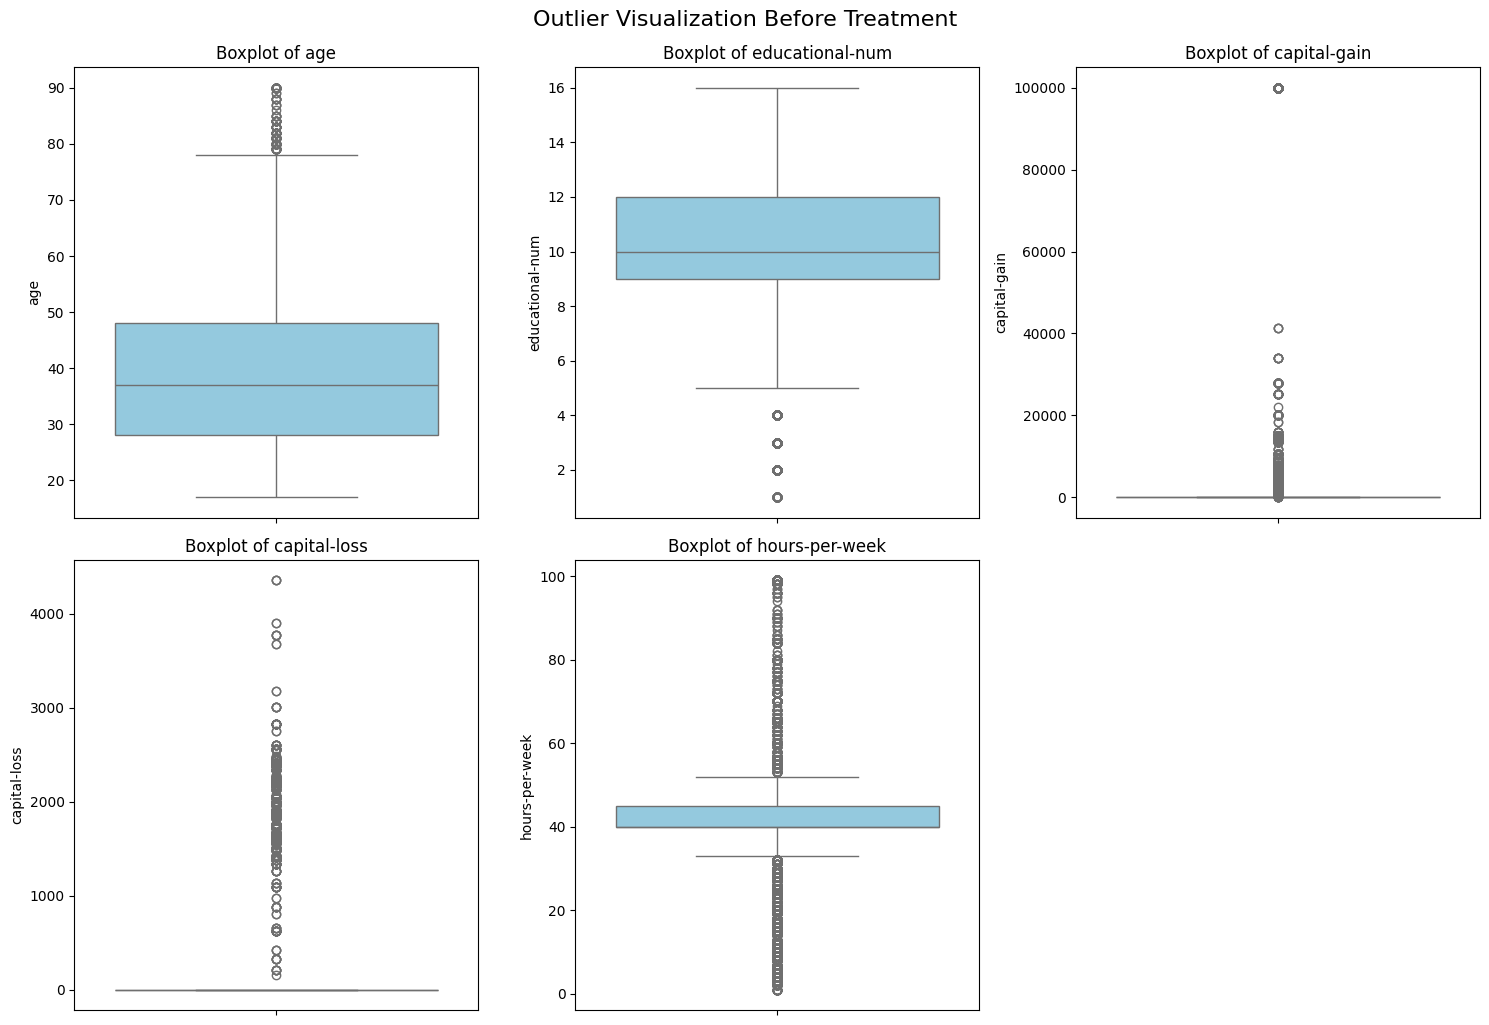

In [7]:
plt.figure(figsize=(15, 10))
numerical_cols = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
plt.tight_layout()
plt.suptitle('Outlier Visualization Before Treatment', y=1.02, fontsize=16)
plt.show()


Outliers have been capped using the IQR method.


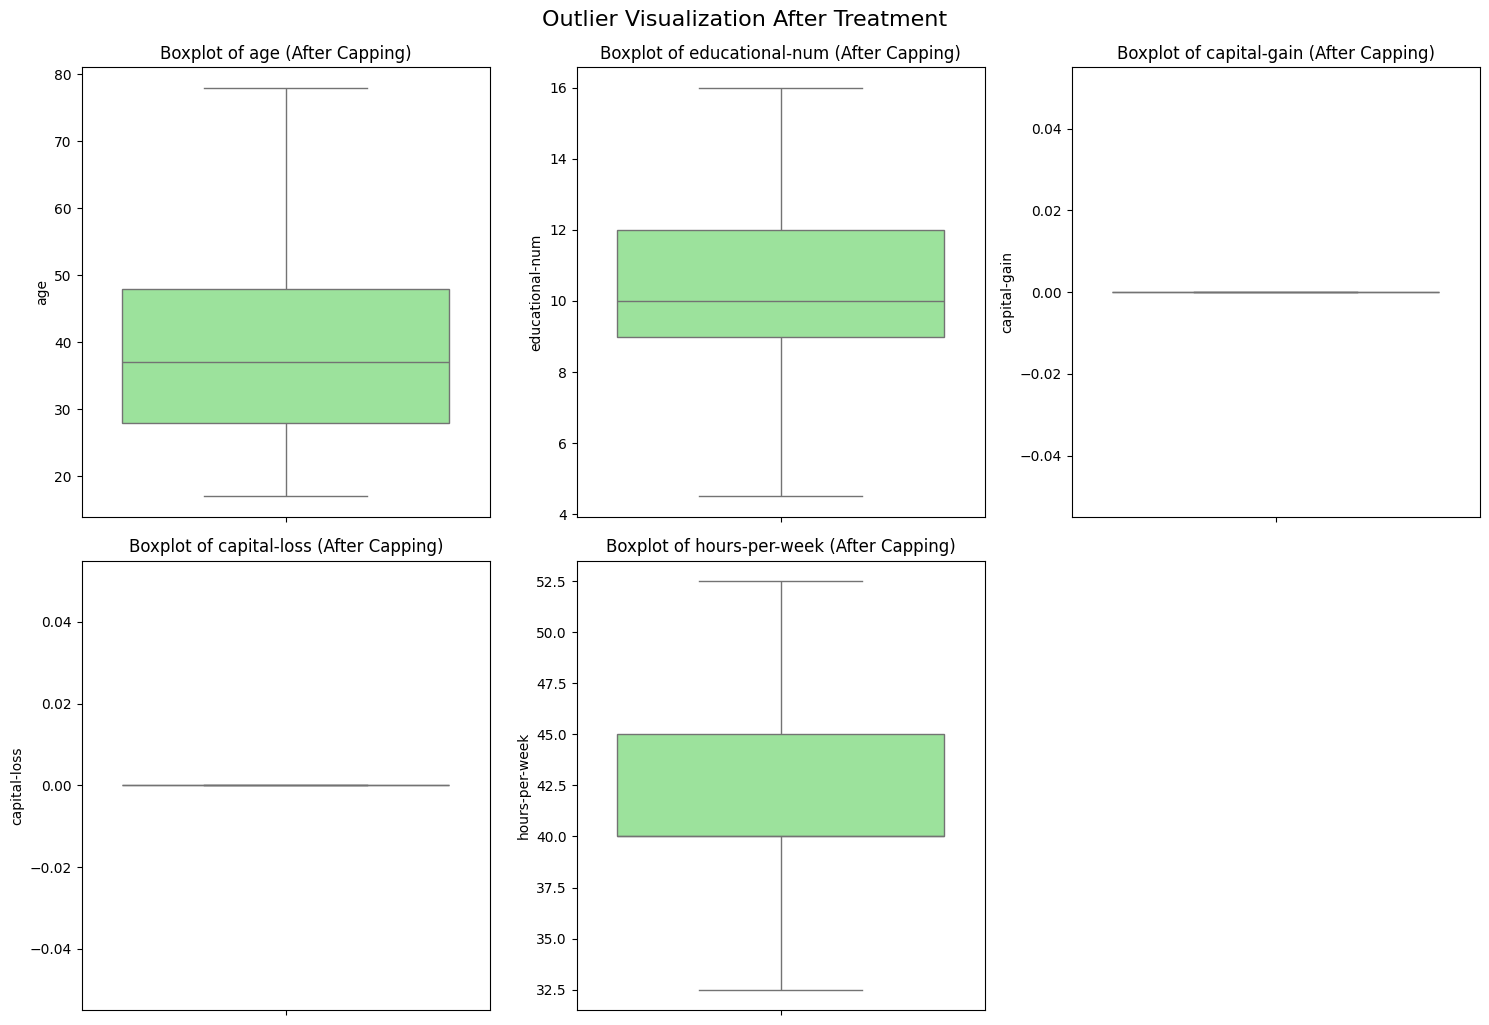

In [8]:
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping the outliers
    df[col] = np.clip(df[col], lower_bound, upper_bound)

print("Outliers have been capped using the IQR method.")

# Visualize after treatment
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col], color='lightgreen')
    plt.title(f'Boxplot of {col} (After Capping)')
    plt.ylabel(col)
plt.tight_layout()
plt.suptitle('Outlier Visualization After Treatment', y=1.02, fontsize=16)
plt.show()


In [9]:
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}

print("--- Encoding Categorical Features ---")
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"Encoded '{col}'")

print("\n--- Data after Encoding ---")
print(df.head())
print("\n--- Data Types after Encoding ---")
df.info()

--- Encoding Categorical Features ---
Encoded 'workclass'
Encoded 'marital-status'
Encoded 'occupation'
Encoded 'relationship'
Encoded 'race'
Encoded 'gender'
Encoded 'native-country'
Encoded 'income'

--- Data after Encoding ---
   age  workclass  educational-num  marital-status  occupation  relationship  \
0   25          3              7.0               4           6             3   
1   38          3              9.0               2           4             0   
2   28          1             12.0               2          10             0   
3   44          3             10.0               2           6             0   
4   18          7             10.0               4          14             3   

   race  gender  capital-gain  capital-loss  hours-per-week  native-country  \
0     2       1             0             0            40.0              38   
1     4       1             0             0            50.0              38   
2     4       1             0             0         

In [10]:

X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: X_train={X_train.shape}")
print(f"Testing set shape: X_test={X_test.shape}")


Training set shape: X_train=(39073, 12)
Testing set shape: X_test=(9769, 12)


In [11]:
pipelines = {
    "LogisticRegression": Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(random_state=42))]),
    "RandomForest": Pipeline([('scaler', StandardScaler()), ('model', RandomForestClassifier(random_state=42))]),
    "KNN": Pipeline([('scaler', StandardScaler()), ('model', KNeighborsClassifier())]),
    "SVM": Pipeline([('scaler', StandardScaler()), ('model', SVC(random_state=42))]),
    "GradientBoosting": Pipeline([('scaler', StandardScaler()), ('model', GradientBoostingClassifier(random_state=42))])
}

print("--- Training Models using Pipelines ---")
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    print(f"'{name}' model trained successfully.")


--- Training Models using Pipelines ---
'LogisticRegression' model trained successfully.
'RandomForest' model trained successfully.
'KNN' model trained successfully.
'SVM' model trained successfully.
'GradientBoosting' model trained successfully.


In [12]:
model_performance = {}

print("\n--- Evaluating Model Performance ---")
for name, pipeline in pipelines.items():
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['<=50K', '>50K'])

    model_performance[name] = accuracy

    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    print("="*50)


--- Evaluating Model Performance ---
--- LogisticRegression ---
Accuracy: 0.8055
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.83      0.94      0.88      7431
        >50K       0.66      0.38      0.48      2338

    accuracy                           0.81      9769
   macro avg       0.75      0.66      0.68      9769
weighted avg       0.79      0.81      0.79      9769

--- RandomForest ---
Accuracy: 0.8177
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.86      0.90      0.88      7431
        >50K       0.64      0.55      0.59      2338

    accuracy                           0.82      9769
   macro avg       0.75      0.72      0.74      9769
weighted avg       0.81      0.82      0.81      9769

--- KNN ---
Accuracy: 0.8204
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.87      0.90      0.88      7431
        >50K       

/tmp/ipython-input-13-353546936.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=performance_df, palette='cubehelix')


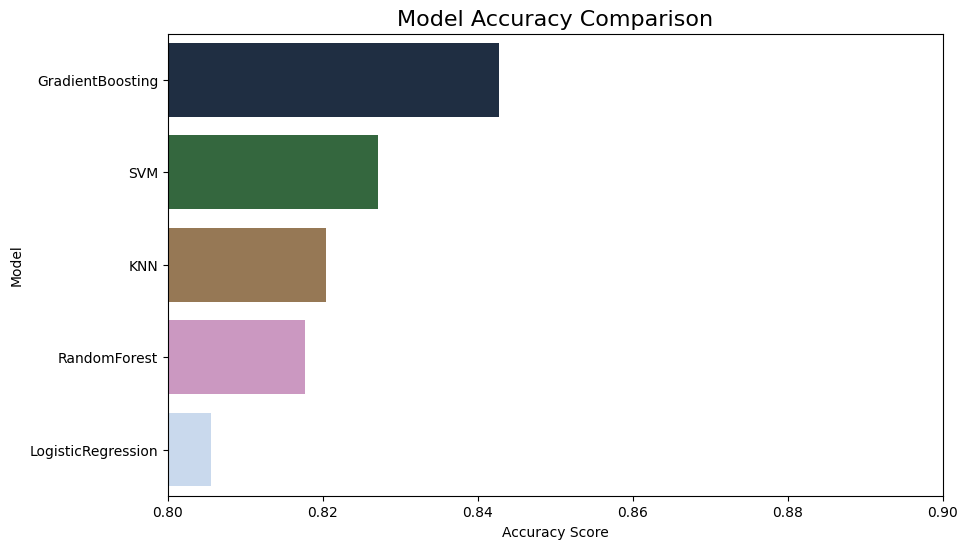

In [13]:

performance_df = pd.DataFrame(list(model_performance.items()), columns=['Model', 'Accuracy']).sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=performance_df, palette='cubehelix')
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Accuracy Score')
plt.xlim(0.8, 0.9)
plt.show()


In [15]:

best_model_name = performance_df.iloc[0]['Model']
best_model_pipeline = pipelines[best_model_name]
best_model_accuracy = performance_df.iloc[0]['Accuracy']

print(f"--- Best Model Selected ---")
print(f"Model: {best_model_name}")
print(f"Accuracy: {best_model_accuracy:.4f}")


--- Best Model Selected ---
Model: GradientBoosting
Accuracy: 0.8427


In [27]:
%%writefile app.py

import streamlit as st
import pandas as pd
import numpy as np
import joblib
import base64

# -------------------------------------------
# Load Saved Artifacts
# -------------------------------------------
@st.cache_resource
def load_artifacts():
    try:
        model = joblib.load('best_model.pkl')
        encoders = joblib.load('label_encoders.pkl')
        return model, encoders
    except FileNotFoundError:
        return None, None

model_pipeline, label_encoders = load_artifacts()

if not model_pipeline:
    st.error("❌ Required model files not found.\n\nPlease ensure 'best_model.pkl' and 'label_encoders.pkl' are present.")
    st.stop()

# -------------------------------------------
# Helper: Download Predictions Link
# -------------------------------------------
def get_table_download_link(df, filename="predictions.csv", text="📥 Download predictions as CSV"):
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode()).decode()
    return f'<a href="data:file/csv;base64,{b64}" download="{filename}">{text}</a>'

# -------------------------------------------
# App UI Configuration
# -------------------------------------------
st.set_page_config(page_title="Income Predictor", layout="wide")
st.title("🧑‍💼 Employee Income Prediction")
st.write("Use this tool to predict whether an individual earns more than ₹50K annually.")

# -------------------------------------------
# Prediction Mode
# -------------------------------------------
prediction_mode = st.radio("📊 Select Prediction Mode", ("Single Prediction", "Batch Prediction"))

# -------------------------------------------
# Single Prediction Mode
# -------------------------------------------
if prediction_mode == "Single Prediction":
    st.sidebar.header("🔍 Enter Employee Details")

    age = st.sidebar.slider("Age", 17, 90, 35)
    workclass = st.sidebar.selectbox("Work Class", label_encoders['workclass'].classes_)
    educational_num = st.sidebar.slider("Education Level (Num)", 1, 16, 10)
    marital_status = st.sidebar.selectbox("Marital Status", label_encoders['marital-status'].classes_)
    occupation = st.sidebar.selectbox("Occupation", label_encoders['occupation'].classes_)
    relationship = st.sidebar.selectbox("Relationship", label_encoders['relationship'].classes_)
    race = st.sidebar.selectbox("Race", label_encoders['race'].classes_)
    gender = st.sidebar.selectbox("Gender", label_encoders['gender'].classes_)
    capital_gain = st.sidebar.number_input("Capital Gain", min_value=0)
    capital_loss = st.sidebar.number_input("Capital Loss", min_value=0)
    hours_per_week = st.sidebar.slider("Hours per Week", 1, 99, 40)
    native_country = st.sidebar.selectbox("Native Country", label_encoders['native-country'].classes_)

    if st.sidebar.button("🧠 Predict Income", type="primary"):
        input_data = {
            'age': age,
            'workclass': workclass,
            'educational-num': educational_num,
            'marital-status': marital_status,
            'occupation': occupation,
            'relationship': relationship,
            'race': race,
            'gender': gender,
            'capital-gain': capital_gain,
            'capital-loss': capital_loss,
            'hours-per-week': hours_per_week,
            'native-country': native_country
        }
        input_df = pd.DataFrame([input_data])

        # Encode categorical features
        for col, encoder in label_encoders.items():
            if col in input_df.columns and col != 'income':
                known_classes = list(encoder.classes_)
                input_df[col] = input_df[col].apply(lambda x: x if x in known_classes else known_classes[0])
                input_df[col] = encoder.transform(input_df[col])

        # Predict
        prediction = model_pipeline.predict(input_df)
        prediction_proba = model_pipeline.predict_proba(input_df)

        # Result
        income_result = label_encoders['income'].inverse_transform(prediction)[0]
        st.success(f"💰 **Predicted Income Category:** {income_result}")

        st.subheader("📈 Prediction Probability")
        st.write(f"- **<=50K:** {prediction_proba[0][0]:.2%}")
        st.write(f"- **>50K:** {prediction_proba[0][1]:.2%}")

# -------------------------------------------
# Batch Prediction Mode
# -------------------------------------------
else:
    st.header("📤 Upload CSV for Batch Prediction")
    uploaded_file = st.file_uploader("Choose a CSV file", type="csv")

    if uploaded_file is not None:
        batch_df = pd.read_csv(uploaded_file)
        st.subheader("📋 Uploaded Data Preview")
        st.dataframe(batch_df.head())

        predict_df = batch_df.copy()

        # Encode categorical features
        for col, encoder in label_encoders.items():
            if col in predict_df.columns and col != 'income':
                known_classes = list(encoder.classes_)
                predict_df[col] = predict_df[col].apply(lambda x: x if x in known_classes else known_classes[0])
                predict_df[col] = encoder.transform(predict_df[col])

        # Predict
        predictions = model_pipeline.predict(predict_df)
        batch_df['predicted_income'] = label_encoders['income'].inverse_transform(predictions)

        st.subheader("✅ Prediction Results")
        st.dataframe(batch_df)

        # Download
        st.markdown(get_table_download_link(batch_df), unsafe_allow_html=True)


Overwriting app.py


In [28]:
from google.colab import files
import joblib # Import joblib

print("\n\n" + "="*80)
print("PROJECT COMPLETE: DEPLOYMENT INSTRUCTIONS & FILE DOWNLOAD")
print("="*80)

print("\nSaving model and encoders...")
# Save the best model pipeline and label encoders
joblib.dump(best_model_pipeline, 'best_model.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
print("Model and encoders saved successfully.")

print("\nTriggering automatic download of deployment files...")

# Trigger downloads
files.download('app.py')
files.download('best_model.pkl')
files.download('label_encoders.pkl')

print("\nDownloads initiated. Please check your browser.")
print("\n--- Next Steps ---")
print("1. Once downloaded, place all three files in the same folder on your local computer.")
print("2. Open a terminal/command prompt in that folder.")
print("3. Install necessary libraries: `pip install streamlit pandas scikit-learn`")
print("4. Launch the app with the command: `streamlit run app.py`")
print("\nYour web browser will open with the interactive prediction app!")
print("="*80)



PROJECT COMPLETE: DEPLOYMENT INSTRUCTIONS & FILE DOWNLOAD

Saving model and encoders...
Model and encoders saved successfully.

Triggering automatic download of deployment files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Downloads initiated. Please check your browser.

--- Next Steps ---
1. Once downloaded, place all three files in the same folder on your local computer.
2. Open a terminal/command prompt in that folder.
3. Install necessary libraries: `pip install streamlit pandas scikit-learn`
4. Launch the app with the command: `streamlit run app.py`

Your web browser will open with the interactive prediction app!
